# Predictive Models

In the last two notebooks we had a look at two of the components of the Basis Mixer. In this notebook we add the third part of the puzzle: the **Predictive Models**.

A predictive model is defined as a mathematical which maps score information (encoded by the basis functions) $\mathbf{\Phi}$ to expressive parameters $\mathbf{Y}$

$$F(\boldsymbol{\Phi}) = \mathbf{Y}$$

## Defining and Building Predictive Models

In [1]:
%matplotlib notebook
import numpy as np
import os
from basismixer import make_datasets
from helper import init_dataset, data
from basismixer.utils import load_pyc_bz, save_pyc_bz
from helper.predictions import (construct_model, setup_output_directory, train_model, 
                                split_datasets)

In [2]:
out_dir = setup_output_directory()

The configuration of the full predictive model can be defined as a list of models defined for individual (or groups) of expressive parameters.

The structure of this configuration can be summarized as follows:

* `onsetwise`: specifies if the model predicts *notewise* or *onsetwise* parameters.
* `basis_functions`: A list with the basis functions (or the familiy of basis functions) used to specify the model. Alternatively, we can use a dataset to specify the basis functions.
* `parameter_names`: Name of the expressive parameters
* `model`: A dictionary specifying the architecture of the model
    * `constructor`: A list specifying the module and method used to construct the model
    * `args`: Arguments for the constructor.
* `train_args`: A dictionary containing parameters for training the model.

Let us define an example of such an architecture

In [3]:
model_config = [
    dict(onsetwise=True,
         basis_functions=['polynomial_pitch_basis',
                          'loudness_direction_basis',
                          'tempo_direction_basis',
                          'articulation_basis',
                          'duration_basis',
                          'slur_basis',
                          'fermata_basis',
                          'grace_basis',
                          'metrical_basis'],
         parameter_names=['velocity_trend', 'beat_period_standardized'],
         model=dict(constructor=['basismixer.predictive_models', 'RecurrentModel'],
                    args=dict(recurrent_size=128,
                              n_layers=1,
                              hidden_size=64)),
         seq_len=50,
         train_args=dict(
             optimizer=['Adam', dict(lr=1e-3)],
             epochs=1,
             save_freq=1,
             early_stopping=100,
             batch_size=100
         )
    )
]

## 2. Making the dataset

In [4]:
init_dataset() # download the corpus if necessary; set some variables

# path to the MusicXML and Match files
xmlfolder = os.path.join(data.DATASET_DIR, 'musicxml')
matchfolder = os.path.join(data.DATASET_DIR, 'match')

dataset_fn = os.path.join(data.DATASET_DIR, 'vienna_4x22.pyc.bz')

Output()

In [5]:
if dataset_fn is not None and os.path.exists(dataset_fn):
    datasets = load_pyc_bz(dataset_fn)
else:
    datasets = make_datasets(model_config,
                             xmlfolder, 
                             matchfolder)
    if dataset_fn is not None:
        save_pyc_bz(datasets, dataset_fn)


## Training the models

Given a training set of expressive performances aligned to their scores, we can train the models in a supervised way by minimizing the *mean squared error* between predictions and the observed expressive parameters.

In [6]:
models = []
test_sets = []
for (dataset, in_names, out_names), config in zip(datasets, model_config):
    
    # Build model
    model, model_out_dir = construct_model(config, in_names, out_names, out_dir)
    # Split datasets
    train_set, valid_set, test_set = split_datasets(dataset)
    # Train Model
    train_model(model, train_set, valid_set, config, model_out_dir)
    
    models.append(model)
    test_sets.append(test_set)


INFO:helper.predictions:Saving config in /tmp/trained_models/velocity_trend-beat_period_standardized-onsetwise/config.json
computing stats: 100%|█████████████████████████| 65/65 [00:00<00:00, 571.05it/s]
INFO:basismixer.predictive_models.train:Saving current best: /tmp/trained_models/velocity_trend-beat_period_standardized-onsetwise/best_model.pth ...
epoch: 1/1 loss: 0.10:  91%|██████████████████▏ | 59/65 [00:04<00:00, 12.72it/s]
INFO:basismixer.predictive_models.train:Training interrupted
INFO:basismixer.predictive_models.train:Loading best model (epoch -1: inf)


<IPython.core.display.Javascript object>


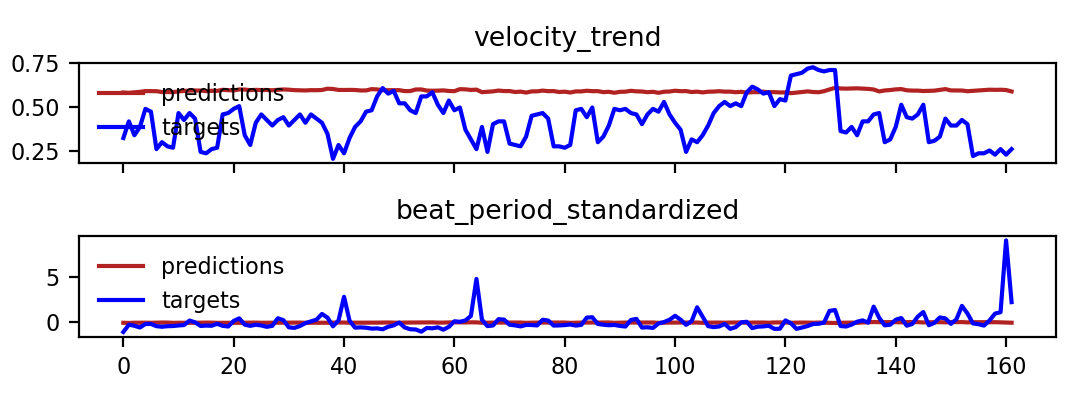

In [7]:
from helper.plotting import plot_predictions_and_targets

for model, test_set in zip(models, test_sets):
    
    basis = test_set.datasets[0].basis
    idx = test_set.datasets[0].idx
    n_basis = test_set.datasets[0].n_basis
    inputs = np.zeros((len(basis), n_basis))
    inputs[:, idx] = basis
    targets = test_set.datasets[0].targets
    preds = model.predict(inputs)

    plot_predictions_and_targets(preds, targets)
